In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
from ggmodel_dev.graphmodel import GraphModel, concatenate_graph_specs
from ggmodel_dev.validation import score_model, plot_diagnostic, score_model_dictionnary

from data_utils.database import select_dataset
from data_utils.utils import get_X_y_from_data, data_dict_from_df_tables

import pandas as pd
import numpy as np

# Data

In [3]:
def prepare_vehicle_data():

    df_tables = ['vehicleownership', 'vehicleownership_gompertz_param']
    
    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    
    #df_dictionnary['vehicleownership'] = df_dictionnary['vehicleownership'].astype({'Year': int})
    
    data_dict = data_dict_from_df_tables([df_dictionnary['vehicleownership'][['ISO', 'Year', 'Variable', 'Value']]])
    
    data_dict.update(data_dict_from_df_tables([df_dictionnary['vehicleownership_gompertz_param'][['ISO', 'Variable', 'Value']]]))
    
    def process_series_0(series_name, series):
        s = series.reset_index(level='Year').dropna().astype({'Year': int}).set_index('Year', append=True)[series_name]
        return s
    
    def process_series_1(series_name, series):
        s = series.dropna().droplevel(level='Year')
        return s
    
    data_dict_0 = {k: process_series_0(k, v) for k, v in data_dict.items() if k not in ['MAX_sat', 'VEHC_mid', 'VEHC_rate']}
    data_dict_1 = {k:v  for k, v in data_dict.items() if k in ['MAX_sat', 'VEHC_mid', 'VEHC_rate']}

    data_dict = {}
    data_dict.update(data_dict_0)
    data_dict.update(data_dict_1)
    
    # No Need for now
    data_dict.pop('Pop', None)
    data_dict.pop('Pop_URB', None)
    data_dict.pop('VEH', None)
    data_dict.pop('Pop_DEN', None)

    return data_dict

data_dict = prepare_vehicle_data()

In [4]:
data_dict.keys()

dict_keys(['GDPC', 'VEHC', 'MAX_sat', 'VEHC_mid', 'VEHC_rate'])

# Model

In [5]:
graph_specifications = {
    'VEHC': {'type': 'output',
             'unit': 'vehicles per 1000 capita',
             'name': 'Vehicle ownership rate',
             'computation': lambda MAX_sat, VEHC_mid, VEHC_rate, GDPC, **kwargs:  MAX_sat * np.exp (-VEHC_mid * np.exp (-VEHC_rate * GDPC))
             },
    'MAX_sat': {'type': 'parameter', # Name to be changed ! 
              'unit': 'vehicles per 1000 capita',
              'name': 'max saturation level',
              },
    'VEHC_mid': {'type': 'parameter',
              'unit': '1',
              'name': 'Vehicle ownership halfway point'},

    'VEHC_rate': {'type': 'parameter',
             'unit': 'capita / constant 2010 US dollar',
             'name': 'Vehicle ownership growth rate'},

    'GDPC': {'type': 'input',
             'unit': 'constant 2010 US dollars per capita',
             'name': 'gross domestic product per capita'}
}

model = GraphModel(graph_specifications)

In [6]:
res = model.run(data_dict)

In [7]:
scores = score_model(model, data_dict)

/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: Runti

In [11]:
scores['score_by_ISO_Variable']

,,r2,correlation,rmse
ISO,Variable,,,
AFG,VEHC,0.448135,0.911840,26.970885
AGO,VEHC,0.519606,0.938665,10.588718
ALB,VEHC,0.509207,0.986143,1126.388430
AND,VEHC,-0.167122,-0.293163,18921.075175
ARE,VEHC,-4.324886,-0.157247,1775.782200
...,...,...,...,...
VNM,VEHC,-0.052569,0.958054,29.462680
YEM,VEHC,-0.487974,-0.785226,3.545465
ZAF,VEHC,0.815969,0.904536,5.230542


# draft

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [13]:
df = (
    pd.concat([res['VEHC'].to_frame(name='Value').assign(type='model'),
               data_dict['VEHC'].to_frame(name='Value').assign(type='measure')])
      .reset_index()
      .merge(scores['score_by_ISO'].reset_index(), on='ISO')
      .astype({'Year': int})
)

In [14]:
plot_df = df.pivot(index=['ISO', 'Year'], columns=['type'], values='Value').reset_index()

In [15]:
ISO_list = scores['score_by_ISO'].sort_values(by='r2').tail(6).index.tolist()

In [16]:
ISO_list

['TUR', 'CRI', 'HUN', 'MAR', 'LIE', 'MCO']

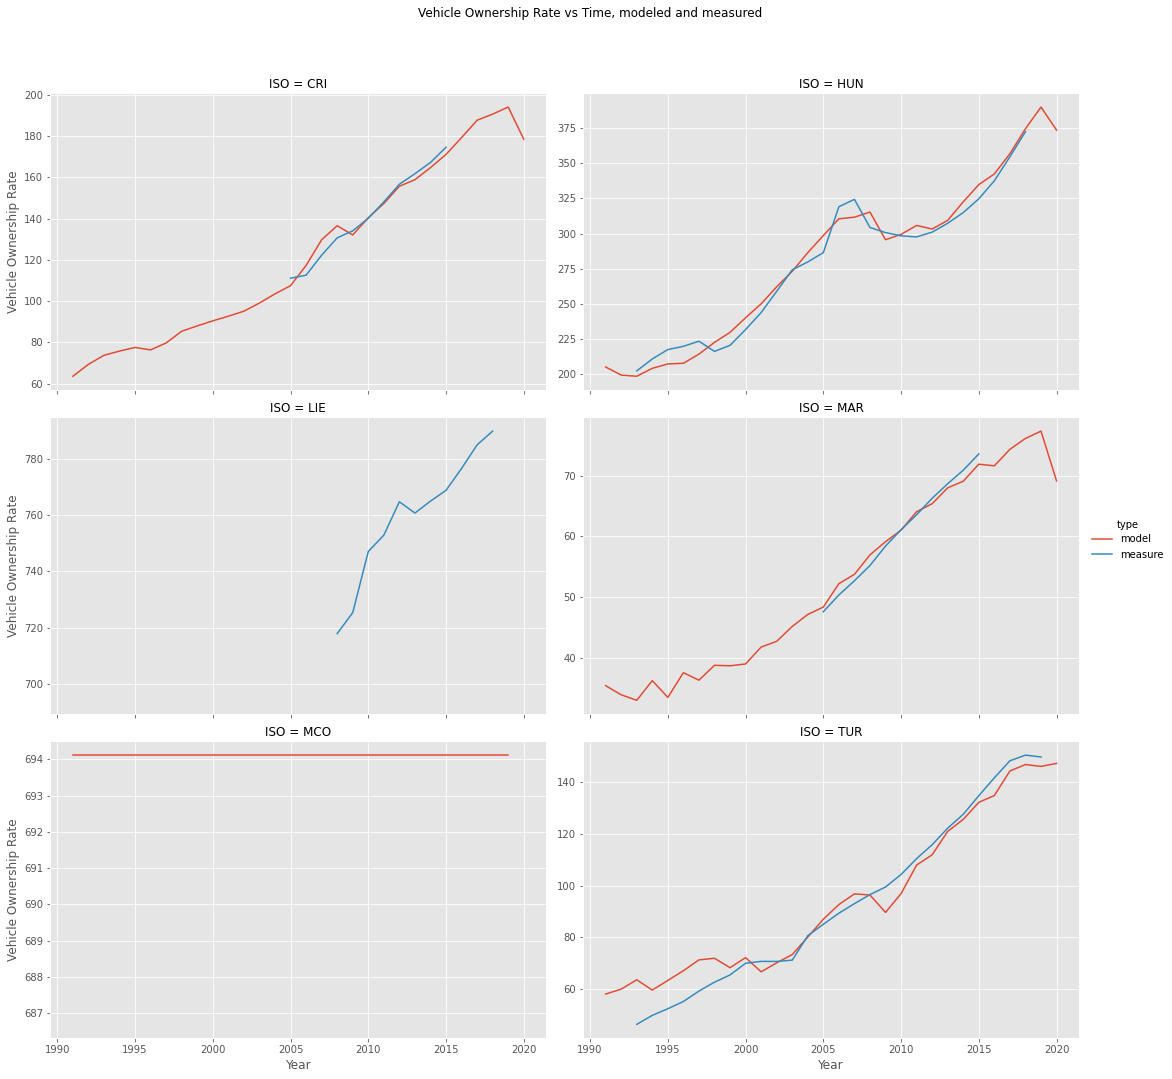

In [17]:
rp = sns.relplot(data=df.query(f'ISO in {ISO_list} and Year > 1990').rename(columns={'Value': 'Vehicle Ownership Rate'}),
            x='Year',
            y='Vehicle Ownership Rate',
            hue='type',
            col='ISO',
            col_wrap=2,
            kind='line',
            height=5,
            aspect=1.5,
            facet_kws=dict(sharey=False),
            )

rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Vehicle Ownership Rate vs Time, modeled and measured')

plt.show()

In [ ]:
from ggdata.scripts import download
def get_WB_variables():
    '''To clean up'''

    to_download =  [
                    ('EN.ATM.PM25.MC.M3', 'PM2.5'),
                    ('NY.GDP.PCAP.KD', 'GDPC'),
    ]

    dfs = []

    for wb_indic, ggi_code in to_download:
        config = {'GGI_code': ggi_code, 'params': {'indicator': wb_indic}}
        
        df = download(API_name='WB', config=config, raw=False)
        
        dfs.append(df)

    df = pd.concat(dfs)
    df = df[~df.ISO.isin([''])]
    
    
    df.loc[df.Variable == 'PM2.5', 'Unit'] = 'micrograms/m3'


    return df

In [ ]:
PM2_5 = get_WB_variables()[['ISO', 'Year', 'Value', 'Variable']]

In [ ]:
VEHC = df.query("type =='measure'")[['ISO', 'Year', 'Value']].assign(Variable='VEHC')
df_1 = pd.concat([VEHC, PM2_5]).astype({'Year': int}).pivot(index=['ISO', 'Year'], columns='Variable', values='Value').dropna().reset_index()

In [ ]:
df_1['VEH/GDP'] = df_1['VEHC'] / df_1['GDPC']

In [ ]:
df_1.groupby('ISO').mean().plot(x='VEH/GDP', y='PM2.5', kind='scatter')

In [ ]:
df_1.groupby('ISO').mean().plot(x='GDPC', y='VEHC', kind='scatter')

In [ ]:
df_1.groupby('ISO').mean().plot(y='PM2.5', x='GDPC', kind='scatter')

In [ ]:
df_1.groupby('ISO').mean().plot(y='PM2.5', x='VEHC', kind='scatter')

# End of draft

In [ ]:
for name, series in data_dict.items():
    series.to_csv(f'data/VEHC/{name}.csv')

In [ ]:
from ggmodel_dev.projection import *
import plotly.express as px

In [ ]:

model_dictionnary = {
    'VEHC_model': model
}


In [ ]:
def run_scenario(data_dict, MAX_sat=1000, GDPC_rate=1.05):
    
    data_dict = data_dict.copy()
    
    print(data_dict['MAX_sat'])

    data_dict['MAX_sat'] = pd.Series(data=data_dict['MAX_sat'].values[0], index=data_dict['GDPC'].index, name='MAX_sat')
    

    scenario_projection_dict = {
        'MAX_sat': lambda x: apply_target_projection(x, MAX_sat),
        'GDPC': lambda x: apply_annual_rate_projection(x, GDPC_rate),
    }
    
    data_dict = run_projection(scenario_projection_dict, data_dict)

    results = model_dictionnary['VEHC_model'].run(data_dict)

    return  results     
    


In [ ]:
def run_all_scenarios_VEHC(data_dict, ISO, args_dict_1, args_dict_2):
    scenarios_results = {}
    data_dict = {k: v.loc[[ISO]] for k, v in data_dict.items()}
    
    
    scenarios_results['BAU'] = run_scenario(data_dict, MAX_sat=data_dict['MAX_sat'], GDPC_rate=1.02)
    scenarios_results['scenario_one'] = run_scenario(data_dict, **args_dict_1)
    scenarios_results['scenario_two'] = run_scenario(data_dict,**args_dict_2)
    
    return scenarios_results


In [ ]:
run_all_scenarios_VEHC(data_dict, 'FRA', {'GDPC_rate': 1.05, 'MAX_sat':500}, {'GDPC_rate': 1.05, 'MAX_sat':700})['scenario_one']